## Knowledge Graph Completion on YAGO3-10

<em>Copyright (c) 2023 Graphcore Ltd. All rights reserved.</em>

In this notebook we will show how to use the BESS-KGE package to perform knowledge graph completion on the YAGO3-10 dataset, a subset of [YAGO3](https://yago-knowledge.org/downloads/yago-3) (Yet Another Great Ontology 3) containing only entities with at least ten relations associated to them.

In [4]:
# Install BESS-KGE from Github releases
import sys
!{sys.executable} -m pip uninstall -y besskge
!pip install -q git+ssh://git@github.com/graphcore-research/bess-kge.git
!pip install -q matplotlib

Found existing installation: besskge 0.1
Uninstalling besskge-0.1:
  Successfully uninstalled besskge-0.1


In [5]:
import pathlib
import time

import matplotlib.pyplot as plt
import numpy as np
import poptorch
import torch

from besskge.batch_sampler import RigidShardedBatchSampler
from besskge.bess import EmbeddingMovingBessKGE, TopKQueryBessKGE
from besskge.dataset import KGDataset
from besskge.embedding import UniformInitializer
from besskge.loss import LogSigmoidLoss
from besskge.metric import Evaluation
from besskge.negative_sampler import (
    PlaceholderNegativeSampler,
    RandomShardedNegativeSampler,
)
from besskge.scoring import ComplEx
from besskge.sharding import PartitionedTripleSet, Sharding

### Entity sharding and triple partitioning

Download and preprocess the dataset with the built-in method of `KGDataset`.

In [6]:
yago = KGDataset.build_yago310(root=pathlib.Path("../datasets/yago310/"))

print(f"Number of entities: {yago.n_entity:,}\n")
print(f"Number of relation types: {yago.n_relation_type}\n")
print(f"Number of triples: \n training: {yago.triples['train'].shape[0]:,} \n validation/test: {yago.triples['validation'].shape[0]:,}\n")

# Print example triple
ex_triple_id = 2500
ex_triple = yago.triples["train"][ex_triple_id]
print(f'Example triple: {yago.entity_dict[ex_triple[0]], yago.relation_dict[ex_triple[1]], yago.entity_dict[ex_triple[2]]}')

Number of entities: 123,182

Number of relation types: 37

Number of triples: 
 training: 1,079,040 
 validation/test: 5,000

Example triple: ('Charles_VIII_of_France', 'isMarriedTo', 'Anne_of_Brittany')


We want to train on 4 IPUs, so we construct a sharding of the entity table in 4 parts. The entity sharding induces a sharding of the triples into 4*4=16 shardpairs, based on the shard of head and tail entities.

In [7]:
seed = 12345
n_shard = 4

sharding = Sharding.create(yago.n_entity, n_shard=n_shard, seed=seed)
print(f"Global entity IDs on {n_shard} shards:")
print(sharding.shard_and_idx_to_entity)

# The global entity IDs can be recovered, as a function of the shard ID and the local ID on the shard, by
print("\nReconstructed global entity IDs:")
print(sharding.shard_and_idx_to_entity[sharding.entity_to_shard, sharding.entity_to_idx])

train_triples = PartitionedTripleSet.create_from_dataset(yago, "train", sharding)

print("\nNumber of triples per (h,t) shardpair:")
print(train_triples.triple_counts)

Global entity IDs on 4 shards:
[[     1      8     10 ... 123164 123168 123180]
 [     2      3     12 ... 123176 123177 123182]
 [     0      5      6 ... 123178 123181 123183]
 [     4      7      9 ... 123170 123173 123179]]

Reconstructed global entity IDs:
[     0      1      2 ... 123179 123180 123181]

Number of triples per (h,t) shardpair:
[[63932 78665 63006 63365]
 [64759 78965 62160 63102]
 [64888 79640 63551 63680]
 [64074 78649 63297 63307]]


To iterate over the sharded set of triples we use a batch sampler.
`RigidShardedBatchSampler` consumes, at each step, the same number of triples from all 16 shardpairs
(resampling from the shorter ones, until the longest one is completed).

To sample negatives during training we use a negative sampler. 
`RandomShardedNegativeSampler` constructs, for each triple, negative samples by sampling random corrupted entities.

See the [biogk_training_inference](1_biokg_training_inference.ipynb) notebook for more details on these classes' options.

In [8]:
device_iterations = 20
accum_factor = 2
shard_bs = 720
neg_sampler = RandomShardedNegativeSampler(n_negative=1, sharding=sharding, seed=seed, corruption_scheme="ht",
                                           local_sampling=False, flat_negative_format=False)
bs = RigidShardedBatchSampler(partitioned_triple_set=train_triples, negative_sampler=neg_sampler, shard_bs=shard_bs,
                              batches_per_step=device_iterations*accum_factor, seed=seed)

In [9]:
options = poptorch.Options()
options.replication_factor = sharding.n_shard
options.deviceIterations(device_iterations)
options.Training.gradientAccumulation(accum_factor)
options._popart.setPatterns(dict(RemoveAllReducePattern=True))

# Construct the dataloader with the dedicated utility function
train_dl = bs.get_dataloader(options=options, shuffle=True, num_workers=5, persistent_workers=True)

# Example batch
batch = next(iter(train_dl))
for k,v in batch.items():
    print(f"{k:<12} {str(v.shape):<30}")

head         torch.Size([40, 4, 4, 180])   
relation     torch.Size([40, 4, 4, 180])   
tail         torch.Size([40, 4, 4, 180])   
triple_mask  torch.Size([40, 4, 4, 180])   
negative     torch.Size([40, 4, 4, 720, 1])


### Training

Let's train the **ComplEx** KGE model with real embedding size 256 and **logsigmoid** loss function, using the `EmbeddingMovingBessKGE` distribution scheme.

In [10]:
loss_fn = LogSigmoidLoss(margin=12.0, negative_adversarial_sampling=True)
emb_initializer = UniformInitializer(range_scale=loss_fn.margin)
complex_score_fn = ComplEx(negative_sample_sharing=True, sharding=sharding, n_relation_type=yago.n_relation_type, embedding_size=256,
                           entity_initializer=emb_initializer, relation_initializer=emb_initializer)
model = EmbeddingMovingBessKGE(negative_sampler=neg_sampler, score_fn=complex_score_fn,
                               loss_fn=loss_fn)

print(f"# model parameters: {model.n_embedding_parameters:,}")

# model parameters: 31,544,576


We are now ready to train.
Let us follow training evolution by computing the MRR on a small random subset of 500 validation queries at regular intervals. To do so we score each query against all entities in the KG and select the top-10 candidate tails with largest scores. We then rank the ground truth tail among the ordered predictions.

As the number of entities in the KG is not so large, we can afford to score the queries on CPU. To see how to speed this task up on IPUs (which is necessary on graphs with more entities, or when scoring a large number of queries) see the next paragraph, *[Top-k inference on IPU](#top-k-inference-on-ipu)*.

In [11]:
def evaluate_mrr_cpu(triples, evaluation):
    
    # Unshard entity embedding table
    ent_table = complex_score_fn.entity_embedding.detach()[sharding.entity_to_shard, sharding.entity_to_idx]

    # Score triple (h,r) against all entities in the KG and select top-10 scores
    scores = complex_score_fn.score_tails(ent_table[triples[:,0]], torch.from_numpy(triples[:,1]), ent_table.unsqueeze(0))
    top_k = torch.topk(scores, dim=-1, k=10)

    ranks = evaluation.ranks_from_indices(torch.from_numpy(triples[:,2]), top_k.indices.squeeze())
    return {k: v / triples.shape[0] for k, v in evaluation.dict_metrics_from_ranks(ranks).items()}

n_val_triples = 500
val_triple_subset = yago.triples["validation"][np.random.RandomState(seed=1000).choice(yago.triples["validation"].shape[0], n_val_triples)]

evaluation = Evaluation(["mrr"], worst_rank_infty=True, reduction="sum")

Graph compilation: 100%|██████████| 100/100 [00:52<00:00]


Epoch 1 loss: 4.515850 --- positive triples processed: 1.38e+06
Epoch duration (sec): 0.60959 (average step time: 0.04017)
Epoch 1 sample MRR: 0.0000
Epoch 2 loss: 0.909071 --- positive triples processed: 2.76e+06
Epoch duration (sec): 0.48422 (average step time: 0.04020)
Epoch 3 loss: 0.689744 --- positive triples processed: 4.15e+06
Epoch duration (sec): 0.48055 (average step time: 0.03989)
Epoch 4 loss: 0.603040 --- positive triples processed: 5.53e+06
Epoch duration (sec): 0.47926 (average step time: 0.03980)
Epoch 5 loss: 0.569874 --- positive triples processed: 6.91e+06
Epoch duration (sec): 0.47910 (average step time: 0.03978)
Epoch 6 loss: 0.570275 --- positive triples processed: 8.29e+06
Epoch duration (sec): 0.48354 (average step time: 0.04011)
Epoch 6 sample MRR: 0.1094
Epoch 7 loss: 0.585809 --- positive triples processed: 9.68e+06
Epoch duration (sec): 0.48275 (average step time: 0.04008)
Epoch 8 loss: 0.608849 --- positive triples processed: 1.11e+07
Epoch duration (sec):

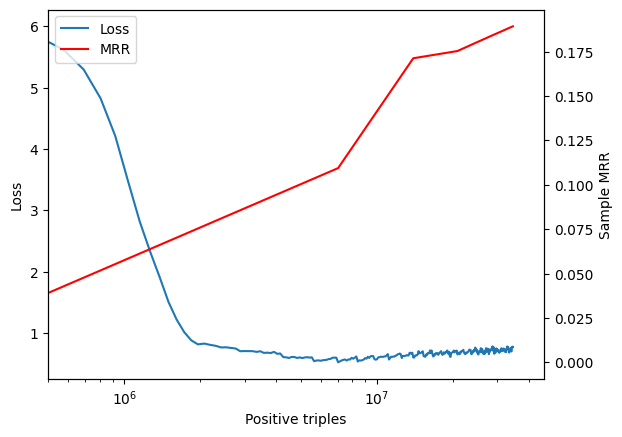

In [12]:
opt = poptorch.optim.AdamW(
        model.parameters(),
        lr=0.0016,
    )

poptorch_model = poptorch.trainingModel(model, options=options, optimizer=opt)

# The variable entity_embedding needs to hold different values on each replica,
# corresponding to the shards of the entity embedding table
poptorch_model.entity_embedding.replicaGrouping(
            poptorch.CommGroupType.NoGrouping,
            0,
            poptorch.VariableRetrievalMode.OnePerGroup,
        )

# Graph compilation
_ = batch.pop("triple_mask")
res = poptorch_model(**{k: v.flatten(end_dim=1) for k, v in batch.items()})

n_epochs = 25
val_ep_interval = 5

cumulative_triples = 0
training_loss = []
val_mrr = []
for ep in range(n_epochs):
    ep_start_time = time.time()
    ep_log = []
    for batch in train_dl:
        step_start_time = time.time()
        triple_mask = batch.pop("triple_mask")
        cumulative_triples += triple_mask.numel()
        res = poptorch_model(**{k: v.flatten(end_dim=1) for k, v in batch.items()})
        ep_log.append(dict(loss=float(torch.sum(res["loss"])) / triple_mask[-1].numel(), step_time=(time.time()-step_start_time)))
    ep_loss = [v['loss'] for v in ep_log]
    training_loss.extend([v['loss'] for v in ep_log])
    print(f"Epoch {ep+1} loss: {np.mean(ep_loss):.6f} --- positive triples processed: {cumulative_triples:.2e}")
    print(f"Epoch duration (sec): {(time.time() - ep_start_time):.5f} (average step time: {np.mean([v['step_time'] for v in ep_log]):.5f})")
    if ep % val_ep_interval == 0:
        ep_mrr = evaluate_mrr_cpu(val_triple_subset, evaluation)["mrr"]
        val_mrr.append(ep_mrr)
        print(f"Epoch {ep+1} sample MRR: {ep_mrr:.4f}")
ep_mrr = evaluate_mrr_cpu(val_triple_subset, evaluation)["mrr"]
val_mrr.append(ep_mrr)
print(f"Final sample MRR: {ep_mrr:.4f}")

# Plot loss and sample MRR as a function of the number of positive triples processed
total_triples = np.cumsum(n_epochs * len(train_dl) * [triple_mask.numel()])
ax0, ax1 = plt.gca(), plt.twinx()
line0, = ax0.plot(total_triples, training_loss)
line1, = ax1.plot(np.concatenate([total_triples[::val_ep_interval * len(train_dl)], total_triples[-1:]]),
                  val_mrr, color="r")
ax0.set_xscale("log")
ax0.set_xlabel("Positive triples")
ax0.set_xlim(xmin=5e5)
ax0.set_ylabel("Loss")
ax1.set_ylabel("Sample MRR")
plt.legend([line0, line1], ["Loss", "MRR"])

poptorch_model.detachFromDevice()
del train_dl

The fact that we are seeing lower metric values compared to the [biogk_training_inference](1_biokg_training_inference.ipynb) case study is not surprising, as here we are making predictions choosing from all 123k+ entities in the KG, while for OGB-BioKG we only had to rank the ground truth against a small set of 500 candidate heads/tails.

### Top-k inference on IPU

On IPU we use the `TopKQueryBessKGE` distribution scheme of BESS to predict, for each validation query, the top-k most likely tails among all the entities in the knowledge graph. Since there are no specific tail candidates to sample, our dataloader does not need to pass negative indices to the IPUs. We therefore use the `PlaceholderNegativeSampler` class.

When using `TopKQueryBessKGE` we partition triples based just on the shard of the head entity (or the tail entity, if we wanted to predict heads), specifying `partition_mode='h_shard'` when constructing the `PartitionedTripleSet`. Moreover, we set the option `return_triple_idx=True` to return the indices of the triples in the batch with respect to the ordered list `validation_triples.triples`.

In [13]:
device_iterations = 1
shard_bs = 1440

validation_triples = PartitionedTripleSet.create_from_dataset(yago, "validation", sharding, partition_mode="h_shard")
candidate_sampler = PlaceholderNegativeSampler(corruption_scheme="t", seed=seed)
bs_valid = RigidShardedBatchSampler(partitioned_triple_set=validation_triples, negative_sampler=candidate_sampler, shard_bs=shard_bs, batches_per_step=device_iterations,
                                    seed=seed, duplicate_batch=False, return_triple_idx=True)

print("Number of triples per h_shard:")
print(validation_triples.triple_counts)

Number of triples per h_shard:
[1254 1226 1248 1272]


In [14]:
val_options = poptorch.Options()
val_options.replication_factor = sharding.n_shard
val_options.deviceIterations(bs_valid.batches_per_step)
val_options.outputMode(poptorch.OutputMode.All)

valid_dl = bs_valid.get_dataloader(options=val_options, shuffle=False, num_workers=5, persistent_workers=True)

# Example batch
batch = next(iter(valid_dl))
for k,v in batch.items():
    print(f"{k:<12} {str(v.shape):<30}")

head         torch.Size([1, 4, 1440])      
relation     torch.Size([1, 4, 1440])      
tail         torch.Size([1, 4, 1440])      
triple_mask  torch.Size([1, 4, 1440])      
triple_idx   torch.Size([1, 4, 1440])      


Notice that, when constructing the partitioned triple set with `partition_mode='h_shard'`, the tensor `head` will contain the **local** entity IDs in the corresponding shard, while `tail` contains the **global** IDs of the ground truth tails:

In [15]:
triple_sorted = yago.triples["validation"][validation_triples.triple_sort_idx]
triple_sorted[:,0] = sharding.entity_to_idx[triple_sorted[:,0]]
np.all(triple_sorted == validation_triples.triples)

True

Let us now compile the inference `TopKQueryBessKGE` model. Notice the parameter `window_size`, which represents the size of the sliding window used to score the queries in the batch against all candidate tails stored on the processing IPU. It determines the number of iterations of the on-device loop used to score candidates: it should be tweaked together with the microbatch size to optimize memory utilization.

In [16]:
# Set worst_rank_infty=True to assign a reciprocal rank of 0 if the ground truth tail is not among the top-10 predicted tails (otherwise the reciprocal rank would be 1/11).
evaluation = Evaluation(["mrr", "hits@3", "hits@10"], worst_rank_infty=True, reduction="sum")
inf_model = TopKQueryBessKGE(k=10, candidate_sampler=candidate_sampler, score_fn=complex_score_fn, evaluation=evaluation, window_size=500)

poptorch_inf_model = poptorch.inferenceModel(inf_model, options=val_options)

poptorch_inf_model.entity_embedding.replicaGrouping(
            poptorch.CommGroupType.NoGrouping,
            0,
            poptorch.VariableRetrievalMode.OnePerGroup,
        )

_ = batch.pop("triple_idx")
res = poptorch_inf_model(**{k: v.flatten(end_dim=1) for k, v in batch.items()})

[13:14:20.038] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 266
[13:14:20.053] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 323
[13:14:20.057] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 346
Graph compilation: 100%|██████████| 100/100 [00:55<00:00]


Iterate over the validation set to compute the predictions and the corresponding metrics.

In [17]:
val_log = []
start_time = time.time()
n_val_queries = 0
for batch_val in valid_dl:
    triple_idx = batch_val.pop("triple_idx")
    step_start_time = time.time()
    res = poptorch_inf_model(**{k: v.flatten(end_dim=1) for k, v in batch_val.items()})
    
    n_val_queries += batch_val["triple_mask"].sum()
    # Filter out padding triples using triple_mask
    val_log.append({k: v.sum() for k, v in zip(
                        evaluation.metrics.keys(),
                        res["metrics"].T,
                    )})

print(f"Validation time (sec): {(time.time() - start_time):.5f}\n")

for metric in val_log[0].keys():
    reduced_metric = sum([l[metric] for l in val_log]) / n_val_queries
    print("%s : %f" % (metric, reduced_metric))

poptorch_inf_model.detachFromDevice()
del valid_dl

Validation time (sec): 0.02383

hits@3 : 0.214400
hits@10 : 0.573200
mrr : 0.209578


Let us check the results (and compare the validation time) against the CPU function defined before.

In [18]:
# Unshard entity embedding table

start_time = time.time()
cpu_res = evaluate_mrr_cpu(yago.triples["validation"], evaluation)

print(f"CPU Validation time (sec): {(time.time() - start_time):.5f}\n")
print(f"CPU validation MRR: {cpu_res['mrr']:.6f}")

CPU Validation time (sec): 0.79809

CPU validation MRR: 0.209578


...and have a look at some of the predictions made by the model

In [19]:
def check_prediction(val_triple_id):
    # Recover the non-padding triples seen in the last batch using triple_idx and triple_mask
    triples = yago.triples["validation"][validation_triples.triple_sort_idx][triple_idx[batch_val["triple_mask"]]]
    h,r,t = triples[val_triple_id]
    # Top-10 tails predicted by the KGE model
    top10_t = res["topk_global_id"][batch_val["triple_mask"].flatten()][val_triple_id]
    
    print(f'Example query: ({yago.entity_dict[h]}, {yago.relation_dict[r]}, ?)\n')
    print(f"Correct tail: {yago.entity_dict[t]}\n")
    print(f"10 most likely predicted tails:")
    for i, pt in enumerate(top10_t):
        print(f"{i+1}) {yago.entity_dict[pt]}" + ("   <-----" if pt == t else ""))
    print("\n")

check_prediction(2000)
check_prediction(3000)

Example query: (Yermy_Hernández, playsFor, ?)

Correct tail: Comayagua_F.C.

10 most likely predicted tails:
1) Heredia_Jaguares_de_Peten
2) C.D._Victoria
3) Platense_F.C.
4) Real_C.D._España
5) Comayagua_F.C.   <-----
6) Honduras_national_football_team
7) F.C._Municipal_Valencia
8) C.D._Marathón
9) C.D.S._Vida
10) Honduras_national_under-20_football_team


Example query: (Éric_Woerth, isAffiliatedTo, ?)

Correct tail: Union_for_a_Popular_Movement

10 most likely predicted tails:
1) Frankfurt_Airport
2) Rally_for_the_Republic
3) Republican_Party_(United_States)
4) Socialist_Party_(France)
5) Amsterdam_Airport_Schiphol
6) Copenhagen_Airport
7) Cardiff_Airport
8) Union_for_a_Popular_Movement   <-----
9) Democratic_Party_(United_States)
10) Cheddi_Jagan_International_Airport




### Scaling analysis

What speed-up did we achieve for top-k inference by using 4 IPUs, compared to running on a single chip? We can change the number of shards of an already existing model like this:

In [20]:
new_val_sharding = Sharding.create(yago.n_entity, n_shard=1, seed=seed)

complex_score_fn.update_sharding(new_sharding=new_val_sharding)

and then re-instantiate dataloader and poptorch model exactly as before:

In [21]:
# Multiply device_iterations by 4 and keep same shard batch size as before
device_iterations = 4
shard_bs = 1440

validation_triples = PartitionedTripleSet.create_from_dataset(yago, "validation", new_val_sharding, partition_mode="h_shard")
bs_valid = RigidShardedBatchSampler(partitioned_triple_set=validation_triples, negative_sampler=candidate_sampler, shard_bs=shard_bs, batches_per_step=device_iterations,
                                    seed=seed, duplicate_batch=False, return_triple_idx=True)

print("Number of triples per h_shard:")
print(validation_triples.triple_counts)

val_options = poptorch.Options()
val_options.replication_factor = new_val_sharding.n_shard
val_options.deviceIterations(bs_valid.batches_per_step)
val_options.outputMode(poptorch.OutputMode.All)

valid_dl = bs_valid.get_dataloader(options=val_options, shuffle=False, num_workers=5, persistent_workers=True)

print("Example batch:")
batch = next(iter(valid_dl))
for k,v in batch.items():
    print(f"{k:<12} {str(v.shape):<30}")

Number of triples per h_shard:
[5000]
Example batch:
head         torch.Size([4, 1, 1440])      
relation     torch.Size([4, 1, 1440])      
tail         torch.Size([4, 1, 1440])      
triple_mask  torch.Size([4, 1, 1440])      
triple_idx   torch.Size([4, 1, 1440])      


In [22]:
inf_model = TopKQueryBessKGE(k=10, candidate_sampler=candidate_sampler, score_fn=complex_score_fn, evaluation=evaluation, window_size=500)

poptorch_inf_model = poptorch.inferenceModel(inf_model, options=val_options)

poptorch_inf_model.entity_embedding.replicaGrouping(
            poptorch.CommGroupType.NoGrouping,
            0,
            poptorch.VariableRetrievalMode.OnePerGroup,
        )

# Compile model
_ = batch.pop("triple_idx")
res = poptorch_inf_model(**{k: v.flatten(end_dim=1) for k, v in batch.items()})

# Run inference
val_log = []
start_time = time.time()
n_val_queries = 0
for batch_val in valid_dl:
    triple_idx = batch_val.pop("triple_idx")
    step_start_time = time.time()
    res = poptorch_inf_model(**{k: v.flatten(end_dim=1) for k, v in batch_val.items()})
    
    n_val_queries += batch_val["triple_mask"].sum()
    val_log.append({k: v.sum() for k, v in zip(
                        evaluation.metrics.keys(),
                        res["metrics"].T,
                    )})

print(f"Validation time (sec): {(time.time() - start_time):.5f}\n")

for metric in val_log[0].keys():
    reduced_metric = sum([l[metric] for l in val_log]) / n_val_queries
    print("%s : %f" % (metric, reduced_metric))

poptorch_inf_model.detachFromDevice()
del valid_dl

[13:15:33.838] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 477
[13:15:33.845] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 534
[13:15:33.848] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 557
Graph compilation: 100%|██████████| 100/100 [01:34<00:00]


Validation time (sec): 0.12103

hits@3 : 0.214400
hits@10 : 0.573200
mrr : 0.209578


By comparing the validation time, we see that **by passing from 1 IPU to 4 IPUs we speed inference up by a factor of >5X**. This more than linear speed-up is explained by the fact that, on top of the usual advantages offered by data parallelism, when using multiple IPUs each of them needs to score queries only against the set of entities stored in its memory, which is a smaller and smaller fraction of the total number of entities the more IPUs are used.